# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
import numpy 
pass


In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 
f1(2,1)

11.0

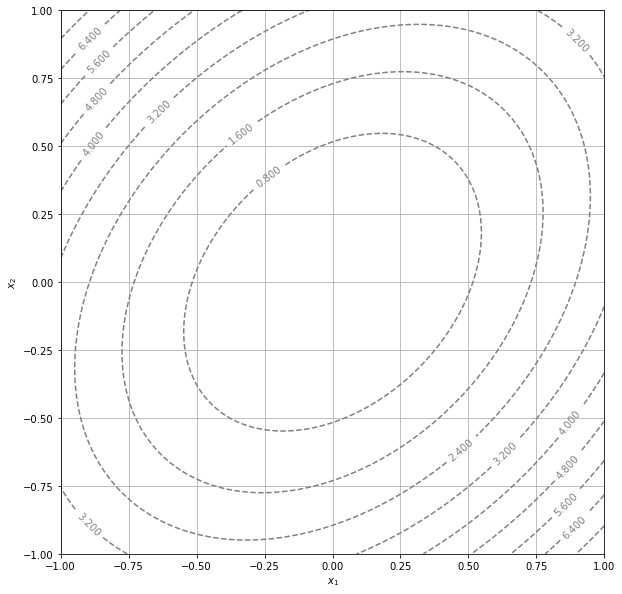

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

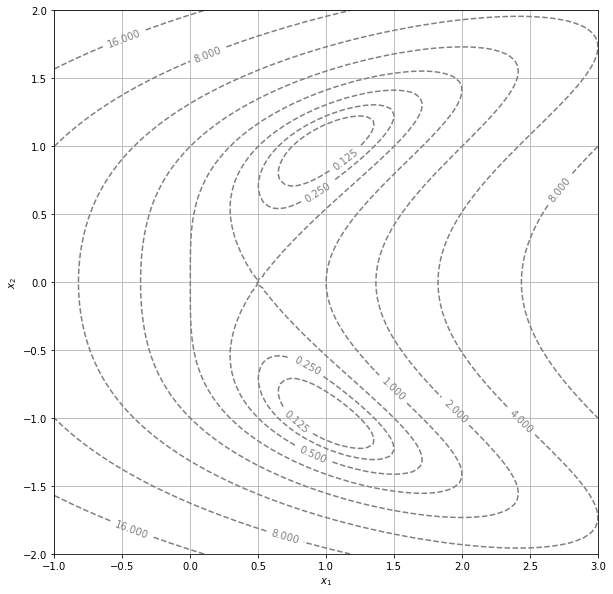

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

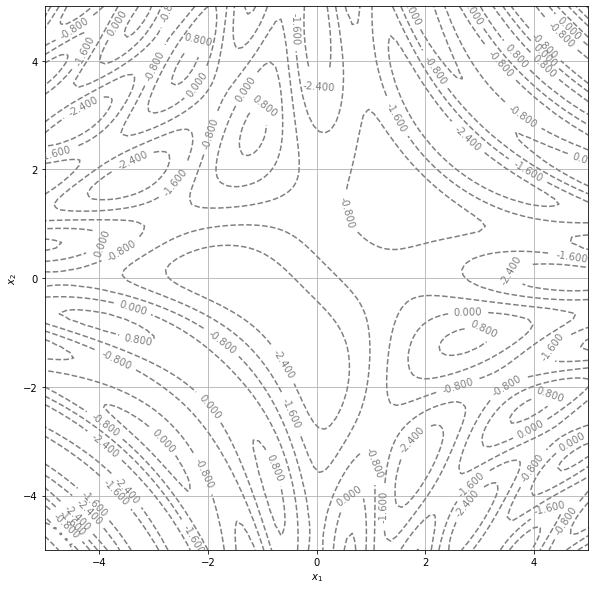

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

#### C est compact

On appelle C l'ensemble de niveau c de f.

-C est fermé: Soit $(X_i)$ une suite d'éléments de C qui converge vers X$ \in \mathbb{R}^2$.   
On a donc $\forall i \in \mathbb{N}$ , $f(X_i)=c$.     
Donc on a directement par continuité de f que f(X)=c.   
Donc C est fermé d'après la caractérisation séquentielle des fermés.


-C est borné:
Par l'absurde on suppose que:
$\forall M>0 \exists X \in C, ||X||>M$
cette relation appliquée à M=n avec n>0 nous fournit une suite $(X_n)$ d'éléments de C tel que:   
$ \forall n \in \mathbb{N}$ $ ||X_n||>n$
Donc on a exhibé une suite d'éléments de C qui diverge en norme mais tel que f($X_n) = c $ ce qui est absurde d'après l'hypothèse vérifiée par f.


Conclusion: C est fermé et borné en dimension finie donc C est compact.


Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

Ce terme correspond à l'aire du parallélogramme engendré par le vecteur position et le gradient au point $(x_1,x_2)$ de la fonction f.
En effet, cela correspond à un déterminant en dimension 2 qui peut donc être interprété géométriquement comme une aire. 

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.



On pose:
$$
g : ((x_1,x_2),t) \in \mathbb{R}^2 *\mathbb{R} \mapsto \begin{pmatrix} f(x_1,x_2)-c \\ p(x_1,x_2)-t \end{pmatrix}
$$                                                                                                                               On a la matrice de la différentielle partielle suivant la 1ère variable de g en $x_0$:
$$
\partial_x g(x_0)  = \begin{pmatrix} \partial_1 f(x_0) & \partial_2 f(x_0)  \\ \frac{\partial_2 f(x_0) }{\|\nabla f(x_0)\|} & -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} \end{pmatrix}
$$  
De déterminant: $$det(\partial_x g)= - (\partial_1 f(x_0) *\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} + \partial_2 f(x_0) *\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|}) $$

Or le gradient de f en $x_0$ est non nul donc :
  $$\partial_1 f(x_0)^2 >0$$ ou $$\partial_2 f(x_0)^2 >0$$ donc $det(\partial_x g) \neq 0$ et $\partial_x g$ est inversible en $x_0$
  
Ainsi on peut appliquer le théorème des fonctions implicites à la fonction g car g est continûment différentiable par composition.
En effet, on a : $g(x_0,0)=0$
Donc il existe un voisinage ouvert U de $x_0$ et V de 0 (donc il existe $\epsilon>0$ tel que $]-\epsilon,\epsilon[ \in V$) tel que $U*V \in \mathbb{R}^2 *\mathbb{R}$ et $\gamma : V \mapsto \mathbb{R}^2$ telle que:
$\forall x \in U, \forall t \in ]-\epsilon,\epsilon[, g(x,t)=0 \Leftrightarrow x=\gamma(t)$

De plus, $p(x_0)=0$ nous fournit un voisinage ouvert W de $x_0$ tel que : $\forall x \in W, p(x) \in  ]-\epsilon,\epsilon[$

Donc en particulier en t=p(x) on a:
$\forall x \in W, g(x,t)=0 \Leftrightarrow f(x)=c$

Donc on a bien:
$\forall x \in W, f(x)=c \Leftrightarrow x=\gamma(t)$ avec t=p(x)







#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

Soit $t \in ]-\epsilon,\epsilon[.$

La différentielle  de $ \gamma $ est donnée par le théorème des fonctions implicites:
    $d\gamma(t) = -(\partial_x g(x,t))^{-1} * \partial_t g(x,t) \\ $
    Or: $ \partial_t g(x,t) = \begin{pmatrix} 0 \\ -1 \end{pmatrix} \\ $
    On note:
  $$ A = \partial_x g(x_0)  = \begin{pmatrix} \partial_1 f(x_0) & \partial_2 f(x_0)  \\ \frac{\partial_2 f(x_0) }{\|\nabla f(x_0)\|} & -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} \end{pmatrix} $$
A est de déterminant non nul et inversible.
On a par ailleurs d'après la formule de la comatrice:
$$
A^{-1} = \frac{1}{det(A)} * com(A)^T
$$
Et :
$com(A)^T=\begin{pmatrix} \partial_1 f(x_0) & -\frac{\partial_2 f(x_0) }{\|\nabla f(x_0)\|}  \\ -\partial_2 f(x_0)  & -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} \end{pmatrix}$

Et on a donc:
$d\gamma(t).1= \gamma'(t) \neq 0$
 On remarque de plus que $\gamma'$ est constante (ne dépend pas de t).
 Donc on a: 
 $f \circ \gamma = c$
 
 Donc en différentiant cette relation on a:
 
 $df(\gamma(t)).\gamma'(t)=0$
 
 Soit: $J_f (\gamma(t)).\gamma'(t)=0$
 
 D'où: $\nabla f(\gamma(t))^T .\gamma'(t)=0$
 
 Donc:
 $(\nabla f(\gamma(t))|\gamma'(t))=0$
 
Donc: $\gamma'(t)$ est orthogonal à $\nabla f(\gamma(t))$.

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

Afin de déterminer un ordre de grandeur de epsilon on étudie la précision de l'affichage. Avec un écran de 16 pouces, et donc de résolution 1920 * 1080 et de longeur 38 cm on a:$\frac{1920}{38} = 51$ pixels par centimètre. Une unité de graphique est donc de 51 pixels. On peut donc prendre $\epsilon=\frac{1}{51}=0.02$.

In [14]:
N = 100
eps = 0.02

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps, N):
    J_F = J(F)
    for i in range(N):
        H=np.array([x0,y0])
        H=H-np.dot(np.linalg.inv(J_F(x0,y0)),F(x0,y0))       
        x,y=H[0],H[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return (x, y)
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) 
vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de re
présenter graphiquement les résultats.

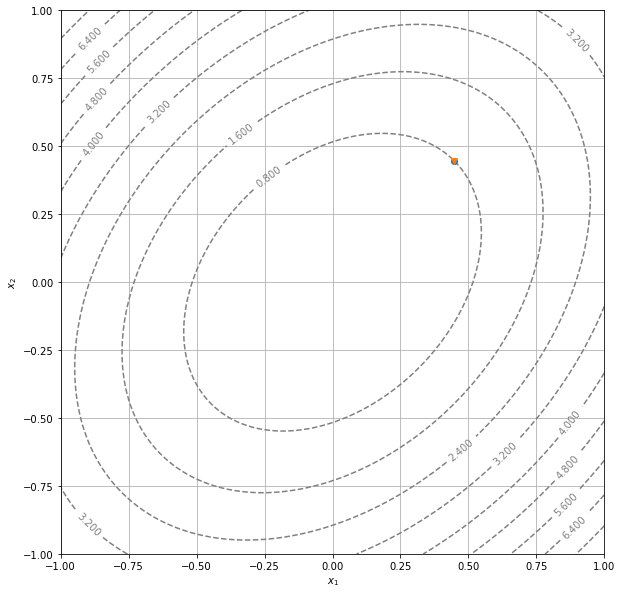

In [16]:
c=0.8

def F1(x1, x2):
    x1=np.array(x1)
    x2=np.array(x2)
    return np.array([3*x1*x1-2*x1*x2+3*x2*x2-c,x2-x1])

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

X0,Y0= Newton(F1,0.8,0.8,eps,N)

plt.plot([X0],[Y0],'o')

X1,Y1=Newton(F1,0.4,0.4,eps,N)    # On remarque que les deux appels de la fonction Newton renvoient le même résultat 
                                  # alors que les coordonées du point d'origine sont bien différentes
plt.plot([X1], [Y1], 'v')

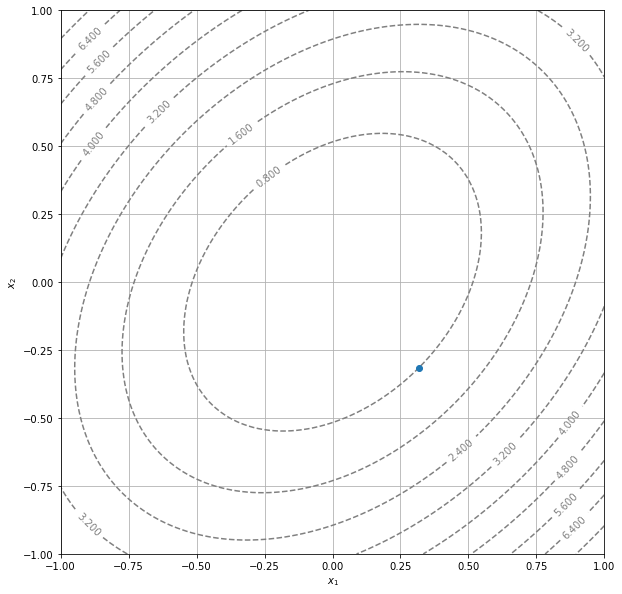

In [17]:
c=0.8

def F1(x1, x2):
    x1=np.array(x1)
    x2=np.array(x2)
    return np.array([3*x1*x1-2*x1*x2+3*x2*x2-c,x2+x1])   # On modifie la contrainte: x1=-x2 

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

X0,Y0= Newton(F1,0.8,-0.8,eps,N)

plt.plot([X0],[Y0],'o')

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

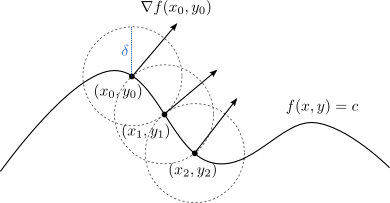

In [18]:
Nombre=100
N=100
def level_curve(f, x0, y0, delta, Nombre, eps):
    R=[[x0,y0]]
    grad_f=grad(f)
    def F(a,b):
        return np.array([f(a,b)-c,(a-x0)**2+(b-y0)**2-delta*delta])
    A= np.array([[0,-1],[1,0]])
    for k in range(1,Nombre):
        Z0=delta*np.array([grad_f(x0,y0)[0],grad_f(x0,y0)[1]])/np.linalg.norm(grad_f(x0,y0)) #on décale le point de la longeur delta pour se rapprocher du point suivant et assurer la convergence de la fonction Newton
        
        Z=np.array([x0,y0])+np.dot(A,Z0)
        B=Newton(F,Z[0],Z[1],eps,N)
        R.append([B[0],B[1]])
        x0,y0=B[0],B[1]
    Res=np.array(R)
    return Res


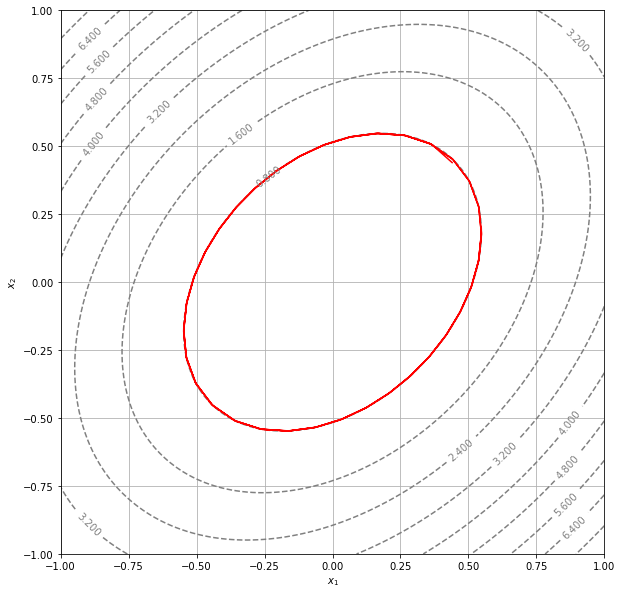

In [19]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
c=0.8
L=level_curve(f1,0.44,0.44, 0.1, Nombre,eps)
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

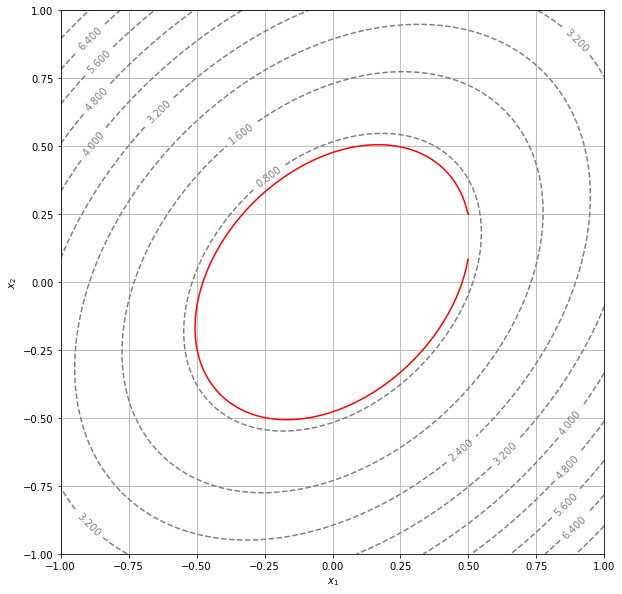

In [20]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
c=0.6825
L=level_curve(f1,0.5,0.25, 0.01, 300,eps)
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

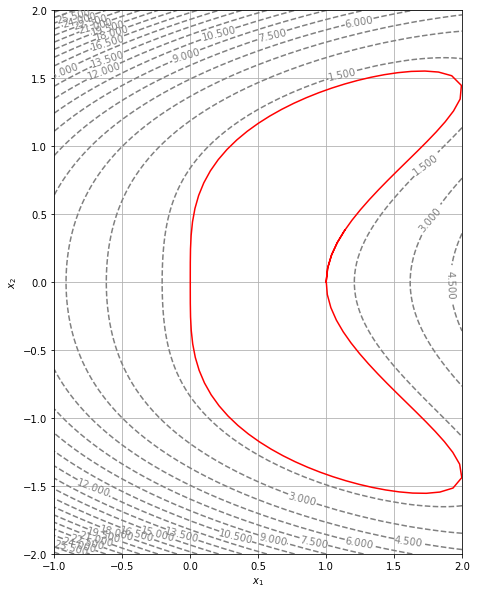

In [21]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 2.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=20 # 10 levels, automatically selected
)
c=1
L=level_curve(f2,1.0,0.0, 0.1, Nombre,eps)
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

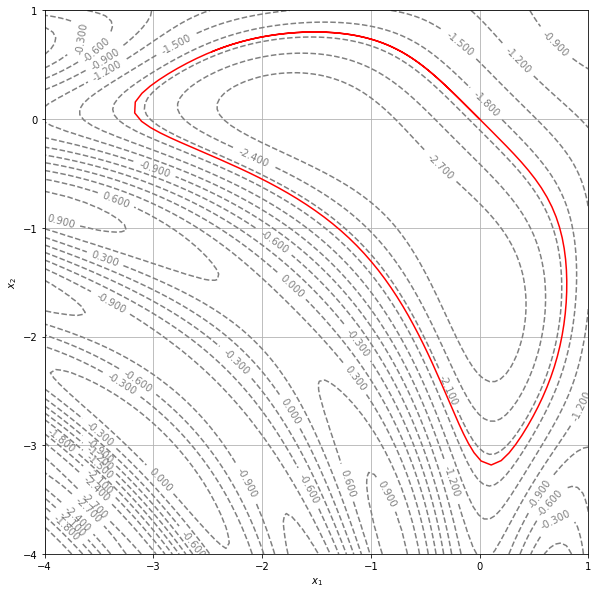

In [22]:
# on va maintenant tester level_curve pour la fonction 3 des exemples de référence


display_contour(
    f3, 
    x=np.linspace(-4.0, 1.0, 100),                       # On ajuste la fenêtre d'affichage pour pouvoir afficher le résultat 
    y=np.linspace(-4.0, 1.0, 100), 
    levels=15 # 10 levels, automatically selected
)
c=-2
L=level_curve(f3,0.0,0.0, 0.1, 150,eps)        # On vérifie bien que f3(0,0)=-2
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

En étant optimiste, on ne peut tester que l'intersection du dernier segment avec le premier. En effet, les courbes de niveau "auto-intersectantes" sont extrêmement rare elles possèdes des points où le gradient s'annule et pourtant ce ne sont pas des extremums. 

En effet, le gradient est perpendiculaire aux lignes de niveau donc pour un point d'intersection de ces lignes "auto-intersectantes", le gradient sera perpendiculaire a deux droites non-colinéaires donc il est nul. 

Dans la réalité, sur une carte géographique par exemple, ce cas correspond à la présence d'un col se situant exactement sur cette ligne de niveau (ce qui est rare).

In [23]:
Nombre=100
N=100
def level_curve2(f, x0, y0, delta, Nombre, eps):
    R=[[x0,y0]]
    grad_f=grad(f)
    def F(a,b):
        return np.array([f(a,b)-c,(a-x0)**2+(b-y0)**2-delta*delta])
    A= np.array([[0,-1],[1,0]])
    for k in range(1,Nombre):
        Z0=delta*np.array([grad_f(x0,y0)[0],grad_f(x0,y0)[1]])/np.linalg.norm(grad_f(x0,y0)) #on décale le point de la longeur delta pour se rapprocher du point suivant et assurer la convergence de la fonction Newton
        
        Z=np.array([x0,y0])+np.dot(A,Z0)
        B=Newton(F,Z[0],Z[1],eps,N)
        if k>3 and intersec_segment(np.array(B),np.array(R[-1]),np.array(R[0]),np.array(R[1]),delta):
            print(f'On est arrivé à une intersection des segments au bout de {k} points placés')
            R.append([B[0],B[1]])
            return np.array(R)
        R.append([B[0],B[1]])
        x0,y0=B[0],B[1]
    Res=np.array(R)
    return Res


def intersec_segment(X0,X1,Y0,Y1,delta): #on considère deux segments de longeur delta [X0,X1] et [Y0,Y1]
    if X1[0]==X0[0] or Y1[0]==Y0[0]:    # il y a un autre cas en plus: si on a un segment horizontal. Cependant 
        return False                    # dans la pratique, cela est extrèmement rare pour le type de foncions considérées
                                        # donc on a choisi d'ignorer les points où on a des intersections ce qui fait tracer un point supplémentaire
    c1=(X1[1]-X0[1])/(X1[0]-X0[0]) #on calcule les coefficients directeurs
    c2=(Y1[1]-Y0[1])/(Y1[0]-Y0[0])
    o1=X0[1]-c1*X0[0]              #on calcule les ordonnées à l'origine
    o2=Y0[1]-c2*Y0[0]
    if c1==c2:
        c3=(Y0[1]-X0[1])/(Y0[0]-X0[0])
        if c3==c1 and ((np.linalg.norm(Y0-X0)<delta and np.linalg.norm(Y0-X1)<delta) or ( np.linalg.norm(Y1-X0)<delta and np.linalg.norm(Y1-X1)<delta)):
            return True
        return False
    else:
        a=(o2-o1)/(c1-c2)
        b=o1+c1*a
        Inter=np.array([a,b])      #coordonées du point d'intersection des deux droites
        if np.linalg.norm(Inter-X0)<delta and np.linalg.norm(Inter-X1)<delta and np.linalg.norm(Inter-Y0)<delta and np.linalg.norm(Inter-Y1)<delta:
            return True
        else:
            return False
        
print( intersec_segment(np.array([0,0]),np.array([1,1]),np.array([0,1]),np.array([1,0]),1)) #on teste la fonction



True


#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

On est arrivé à une intersection des segments au bout de 35 points placés


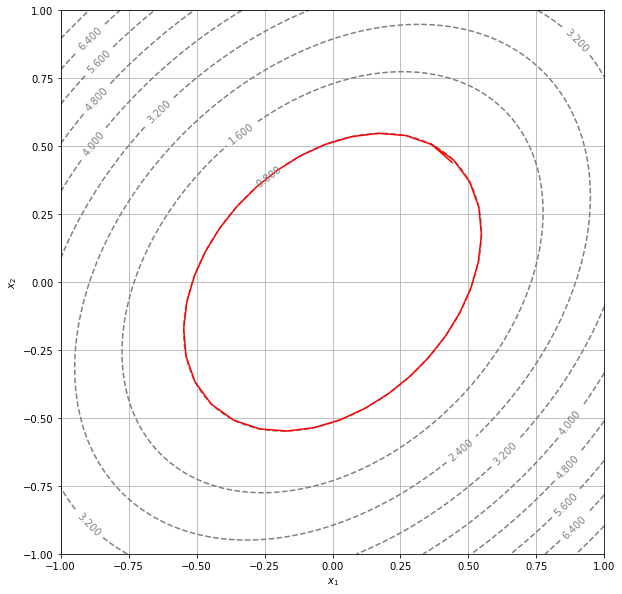

In [24]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
c=0.8
L=level_curve2(f1,0.44,0.44, 0.1, Nombre,eps)
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

On est arrivé à une intersection des segments au bout de 95 points placés


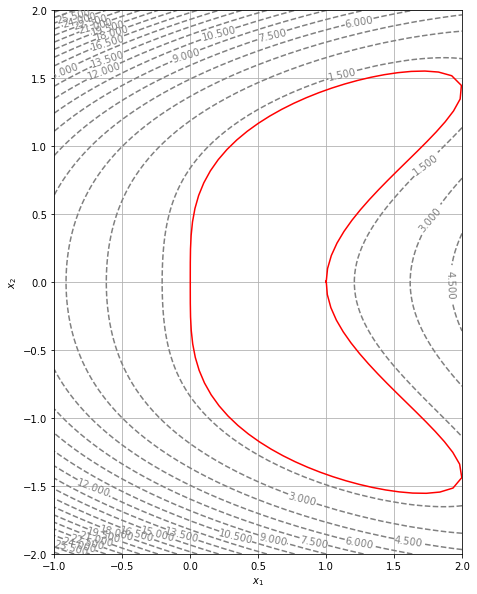

In [25]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 2.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=20 # 10 levels, automatically selected
)
c=1
L=level_curve2(f2,1.0,0.0, 0.1, Nombre,eps)
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

On est arrivé à une intersection des segments au bout de 122 points placés


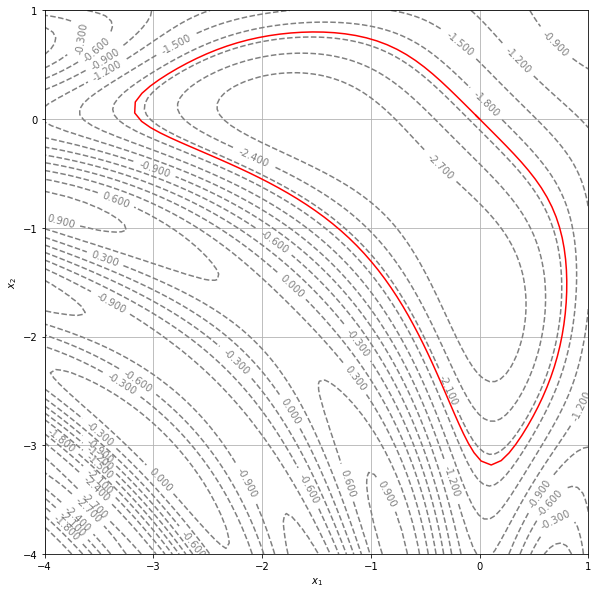

In [26]:
display_contour(
    f3, 
    x=np.linspace(-4.0, 1.0, 100),                       # On ajuste la fenêtre d'affichage pour pouvoir afficher le résultat 
    y=np.linspace(-4.0, 1.0, 100), 
    levels=15 # 10 levels, automatically selected
)
c=-2
L=level_curve2(f3,0.0,0.0, 0.1, 150,eps)        # On vérifie bien que f3(0,0)=-2
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

on écrit : $P_1=\begin{pmatrix} x_1 \\ y_1 \end{pmatrix}$, $P_2=\begin{pmatrix} x_2 \\ y_2 \end{pmatrix}$, $u_1=\begin{pmatrix} \alpha_1 \\ \beta_1 \end{pmatrix}$ et $u_2=\begin{pmatrix} \alpha_2 \\ \beta_2 \end{pmatrix}$


L'évaluation de la fonction $\gamma$ en O donne la relation:

$\begin{pmatrix} a \\ d \end{pmatrix} = P_1$

L'évaluation de la fonction $\gamma$ en 1 donne la relation:

$\begin{pmatrix} b+c \\ e+f \end{pmatrix} = P_2 - P_1$

Enfin les relations liés à la dérivée de $\gamma$ donnent:

$\begin{pmatrix} b+2c \\ e+2f \end{pmatrix} = \lambda u_1$  et   $\begin{pmatrix} b \\ e \end{pmatrix} = \mu u_2$ 

où $\lambda$ et $\mu$ sont deux constantes positives.

Ainsi en sommant ces deux dernières relations on a:
$\lambda * u_1 + \mu * u_2 = 2*(P_2 - P_1)$           (**)

On se retrouve ainsi avec un problème d'algèbre dans $\mathbb{R}^2$

#### 1er cas: la famille $(u_1 , u_2)$ est libre

on a donc que cette famille est une base de $\mathbb{R}^2$

il existe donc des uniques $\lambda$ et $\mu$ qui vérifient la relation **.
    
On considère un vecteur $v_1$ orthogonal à $u_1$ et un vecteur $v_2$ orthogonal à $u_2$.

Par exemple on peut poser: $v_1=\begin{pmatrix} 0 & -1   \\ 1 & 0 \end{pmatrix} *u_1$ et  $v_2=\begin{pmatrix} 0 & -1   \\ 1 & 0 \end{pmatrix} *u_2$
    
On multiplie scalairement par $v_1$ la relation **:
    
$ \mu * <u_2,v_1> = 2*<(P_2 - P_1),v_1>$ et on obtient donc $\mu = \frac{2*<(P_2 - P_1),v_1>}{ <u_2,v_1>}$

On effectue la même chose avec $v_2$ et on trouve:

$\lambda = \frac{2*<(P_2 - P_1),v_2>}{ <u_1,v_2>}$

On a à l'aide des relations obtenues précédemment:

$a=x_1$  
$d=y_1$  
$b=\lambda * \alpha_1$  
$e=\lambda * \beta_1$   
$c=\frac{\mu * \alpha_2 - \lambda * \alpha_1}{2}$     
$f=\frac{\mu * \beta_2 - \lambda * \beta_1}{2}$ 

#### 2ème cas: la famille $(u_1 , u_2)$ est liée

Si le coefficient directeur de la droite passant par $P_1$ et $P_2$ est colinéaire à $u_1$:

Si une droite rectiligne peut correspondre en respectant les conditions sur les vecteurs $u_1$ et $u_2$ (autrement dit si $u_1$ et $u_2$ sont positivement colinéaires) alors on a les coefficients de manière trivial:

$a=x_1$  
$d=y_1$   
$b=x_2-x_1$   
$e=y_2-y_1$   
$c=0$     
$f=0$

Sinon on a dans tout les cas un problème d'interpolation qui est impossible à satisfaire avec un polynôme de degré 2.

Si le coefficient directeur de la droite passant par $P_1$ et $P_2$ n'est pas colinéaire à $u_1$:

Alors la courbe de $\gamma$ présente nécessairement deux points d'annulation de la dérivée or on effectue une interpolation avec des polynômes de degré 2 qui présentent un seul de ces points d'annulation donc cette interpolation est impossible avec les exigences demandées.

#### Conclusion

On a donc une interpolation possible avec les exigences demandées si:

- la famille $(u_1 , u_2)$ est libre

- la famille $(u_1 , u_2)$ est liée et $u_1$ et $u_2$ sont positivement colinéaires

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [27]:
def gamma(t,P1,P2,u1,u2):
    if u1[0]*u2[1] == u2[0]*u1[1]:    #la famille( u1,u2) est liée
        return np.array([P1[0]+t*(P2[0]-P1[0]),P1[1]+t*(P2[1]-P1[1])])                # on peut appliquer des fonctions a des tableaux numpy
    else:                            # la famille (u1,u2) est libre
        v1=np.dot([[0,-1],[1,0]],u1)             #on sélectionne des vecteurs orthogonaux à u1 et u2
        v2=np.dot([[0,-1],[1,0]],u2)
        mu=2*np.vdot(P2-P1,v1)/np.vdot(u2,v1)    # les coefficients intermédiares trouvés dans la question 8
        lam=2*np.vdot(P2-P1,v2)/np.vdot(u1,v2)
        A=P1[0]                      #on calcule les coefficients trouvé à l'aide de la question 8
        B=lam*u1[0]
        C=(mu*u2[0]-lam*u1[0])/2
        D=P1[1]
        E=lam*u1[1]
        F=(mu*u2[1]-lam*u1[1])/2
        return np.array([A+B*t+C*t*t,D+E*t+F*t*t])

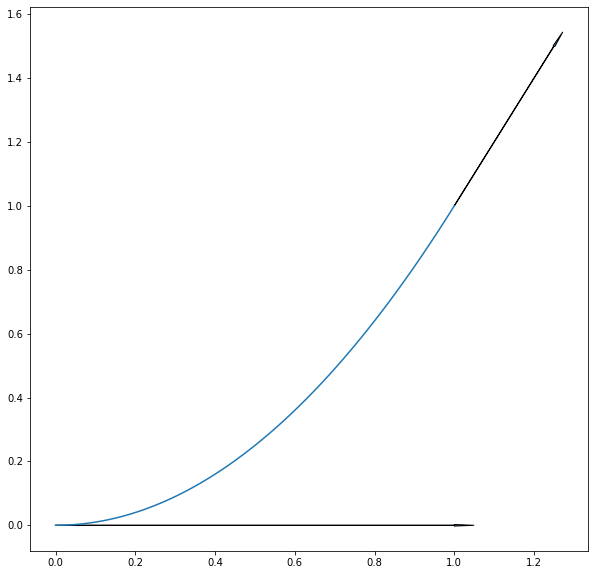

In [28]:
# ON A DANS LE CAS GENERAL

ax=plt.axes()

P1=np.array([0,0])
P2=np.array([1,1])
u1=np.array([1,0])
u2=np.array([0.25,0.5])
t=np.linspace(0,1,100)
G=gamma(t,P1,P2,u1,u2).T

abs=[G[k][0] for k in range(100)]
ord=[G[k][1] for k in range(100)]
plt.plot(abs,ord)
ax.arrow(P1[0],P1[1],u1[0],u1[1],head_width=0.005,head_length=0.05)
ax.arrow(P2[0],P2[1],u2[0],u2[1],head_width=0.005,head_length=0.05)

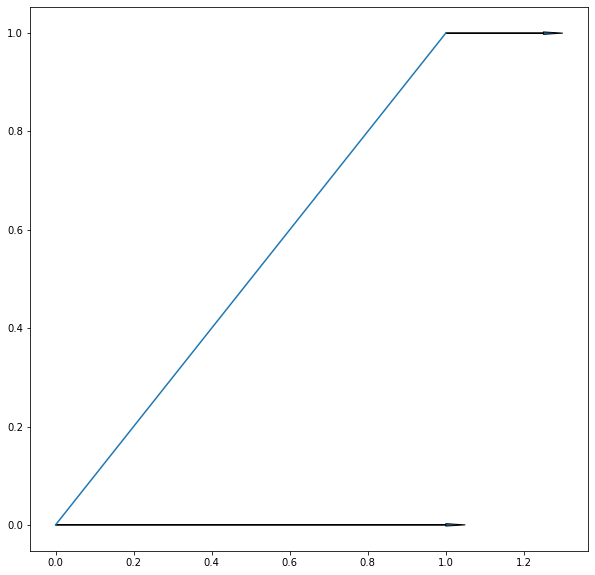

In [29]:
# ON TESTE UN CAS PARTICULIER DE COLINEARITE

ax=plt.axes()

P1=np.array([0,0])
P2=np.array([1,1])
u1=np.array([1,0])
u2=np.array([0.25,0])
t=np.linspace(0,1,100)
G=gamma(t,P1,P2,u1,u2).T

abs=[G[k][0] for k in range(100)]
ord=[G[k][1] for k in range(100)]
plt.plot(abs,ord)
ax.arrow(P1[0],P1[1],u1[0],u1[1],head_width=0.005,head_length=0.05)
ax.arrow(P2[0],P2[1],u2[0],u2[1],head_width=0.005,head_length=0.05)

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [30]:
def level_curve3(f, x0, y0, delta, Nombre, eps, oversampling):
    if oversampling==1:
        return level_curve2(f, x0, y0, delta, Nombre, eps)
    else:
        t= np.array([i/oversampling for i in range(1,oversampling)])  # on exclue les extremums car ils seront déjâ calculé dans la boucle for
        R=[[x0,y0]]
        grad_f=grad(f)
        def F(a,b):
            return np.array([f(a,b)-c,(a-x0)**2+(b-y0)**2-delta*delta])
        A= np.array([[0,-1],[1,0]])
        for k in range(1,Nombre):
            Z0=delta*np.array([grad_f(x0,y0)[0],grad_f(x0,y0)[1]])/np.linalg.norm(grad_f(x0,y0)) #on décale le point de la longeur delta pour se rapprocher du point suivant et assurer la convergence de la fonction Newton        
            Z=np.array([x0,y0])+np.dot(A,Z0)
            B=Newton(F,Z[0],Z[1],eps,N)
            
            u1 = np.array([[0,-1],[1,0]]).dot(grad_f(R[-1][0],R[-1][1]))
            u2 = np.array([[0,-1],[1,0]]).dot(grad_f(B[0],B[1]))
            G = gamma(t, np.array(R[-1]), np.array(B), u1, u2).T  
            g=list(G)
            for i in range(len(t)):
                R.append(g[i])
            if k>2 and intersec_segment(np.array(B), np.array(R[-1]), np.array(R[0]), np.array(R[1]), delta):
                print(f'On est arrivé à une intersection des segments au bout de {k} points placés')
                R.append([B[0],B[1]])
                return np.array(R)
            R.append([B[0],B[1]])
            x0,y0=B[0],B[1]
        Res=np.array(R)
        return Res

    
    ##2eme METHODE
#def level_curve3(f, x0, y0, delta, Nombre, eps, oversampling):
#    List = level_curve2(f, x0, y0, delta, Nombre, eps)
#    if oversampling==1:
#        return List
#    else:
#        R=[List[0]]                                                  # On crée la liste des résultat
#        grad_f=grad(f)
#        t= np.array([i/oversampling for i in range(1,oversampling)])  # on exclue les extremums car ils seront déjâ ajouté dans la liste avec la boucle for
#        for k in range (len(List)-1):
#            u1 = np.array([[0,-1],[1,0]]).dot(grad_f(List[k][0],List[k][1]))
#            u2 = np.array([[0,-1],[1,0]]).dot(grad_f(List[k+1][0],List[k+1][1]))
#            G = gamma(t, np.array(List[k]), np.array(List[k+1]), u1, u2)  
#            g=list(G)
#            for i in range(len(g)):
#                R.append(g[i])
#            R.append(List[k+1])
#        print(R)
#        return np.array(R)

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

On est arrivé à une intersection des segments au bout de 18 points placés


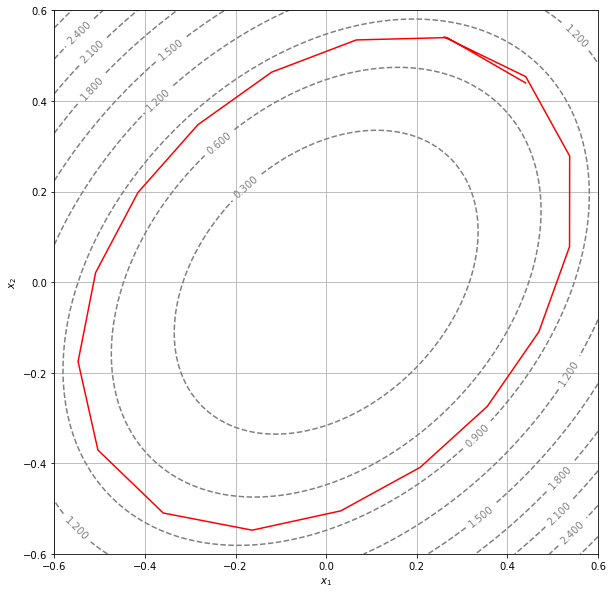

In [31]:
# on vérifie que ca marche bien pour oversampling=1

display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels=10 # 10 levels, automatically selected
)
c=0.8
L=level_curve3(f1, 0.44, 0.44, 0.2, 50, eps, 1)
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

On est arrivé à une intersection des segments au bout de 17 points placés


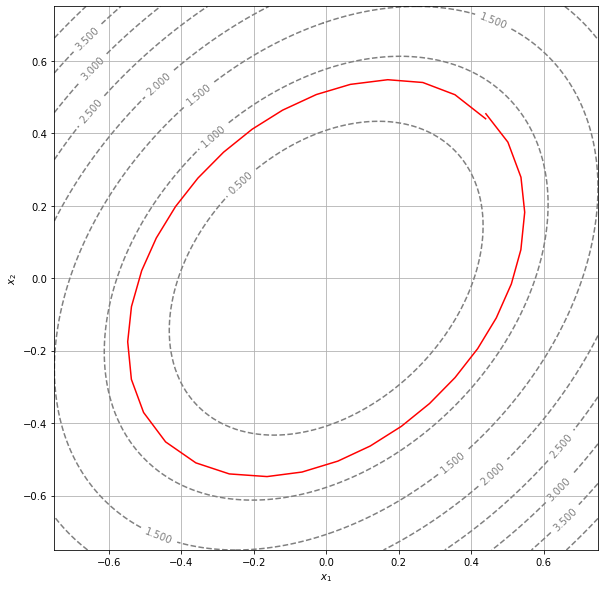

In [32]:
#On teste dans un cadre plus général

display_contour(
    f1, 
    x=np.linspace(-0.75, 0.75, 100), 
    y=np.linspace(-0.75, 0.75, 100), 
    levels=10 # 10 levels, automatically selected
)
c=0.8
L=level_curve3(f1, 0.44, 0.44, 0.2, 50, eps, 2)
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

On est arrivé à une intersection des segments au bout de 8 points placés


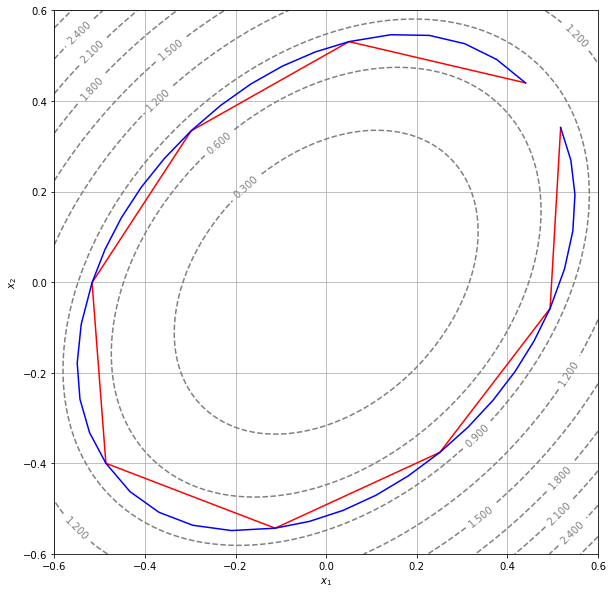

In [33]:
#On superpose les deux cas précédent pour montrer les avantages de cette méthode

display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels=10 # 10 levels, automatically selected
)
c=0.8
L=level_curve3(f1, 0.44, 0.44, 0.4, 9, eps, 1)
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

T=level_curve3(f1, 0.44, 0.44, 0.4, 9, eps, 5)
abs=[]
ord=[]
for I in range(len(T)):
    abs.append(T[I][0])
    ord.append(T[I][1])
plt.plot(abs,ord,color='blue')


On est arrivé à une intersection des segments au bout de 47 points placés


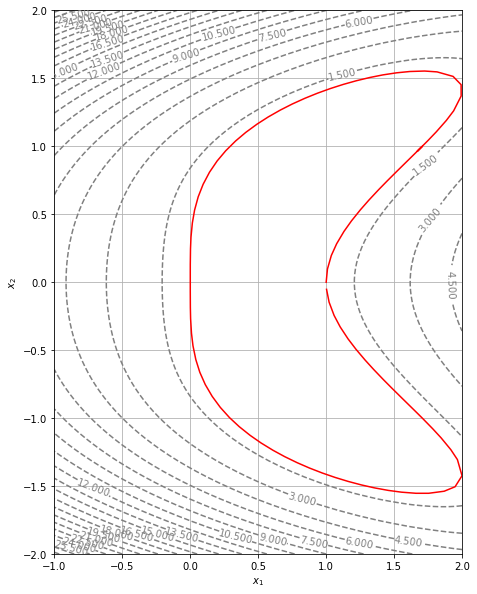

In [34]:
#Pour la fonction 2

display_contour(
    f2, 
    x=np.linspace(-1.0, 2.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=20 # 10 levels, automatically selected
)
c=1
L=level_curve3(f2,1.0,0.0, 0.2, Nombre,eps,2)
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

On est arrivé à une intersection des segments au bout de 18 points placés
On est arrivé à une intersection des segments au bout de 17 points placés


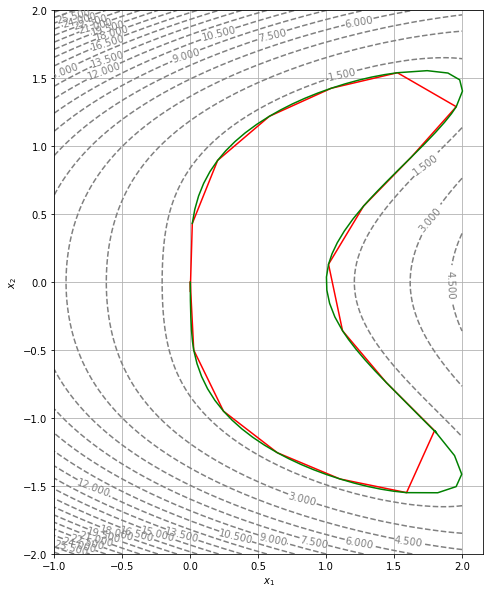

In [35]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 2.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=20 # 10 levels, automatically selected
)
c=1
L=level_curve3(f2,0.0,0.0, 0.5, 50,eps,1)
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

T=level_curve3(f2,0.0,0.0, 0.5, 50,eps,5)
#print(T)
abs=[]
ord=[]
for i in range(len(T)):
    abs.append(T[i][0])
    ord.append(T[i][1])
plt.plot(abs,ord,color='green')

On est arrivé à une intersection des segments au bout de 49 points placés
On est arrivé à une intersection des segments au bout de 48 points placés


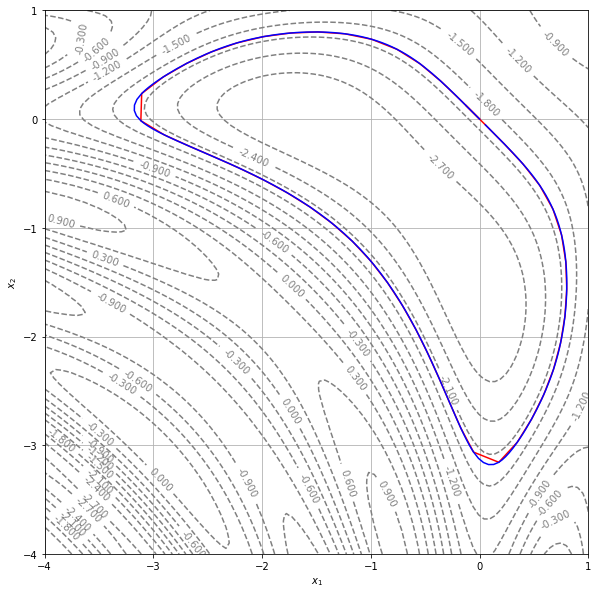

In [36]:
display_contour(
    f3, 
    x=np.linspace(-4.0, 1.0, 100),                       # On ajuste la fenêtre d'affichage pour pouvoir afficher le résultat 
    y=np.linspace(-4.0, 1.0, 100), 
    levels=15 # 10 levels, automatically selected
)
c=-2
L=level_curve3(f3,0.0,0.0, 0.25, 50,eps , 1)        
#print(L)
abs=[]
ord=[]
for I in range(len(L)):
    abs.append(L[I][0])
    ord.append(L[I][1])
plt.plot(abs,ord,color='red')

T=level_curve3(f3,0.0,0.0, 0.25, 65,eps, 5)        
#print(L)
abs=[]
ord=[]
for I in range(len(T)):
    abs.append(T[I][0])
    ord.append(T[I][1])
plt.plot(abs,ord,color='blue')